In [1]:
# check for requirements.txt

import os
import sys
import argparse
from omegaconf import OmegaConf
from omegaconf import DictConfig
import torch
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# from torch.utils.tensorboard import SummaryWriter # Not available at Pytorch 1.2 version.
from torchvision.datasets import FashionMNIST
from torchvision import transforms # callable
from tqdm import tqdm
from datetime import datetime

In [2]:
# check if GPu is available
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [3]:
project_root = os.getcwd()
data_root = os.path.join(project_root,'data')
model_root = os.path.join(project_root,'logs')

In [4]:
# Preprocessing & Dataset definition
# Composes several transforms together.
transform = transforms.Compose( 
    [
    transforms.ToTensor(), # PIL Image or ndarray-> FloatTensor with (c,h,w), Intensity to [0,1]
    transforms.Normalize([0.5],[0.5]) # normalize each channel of the input
    # mean (sequence) – Sequence of means for each channel.
    # std (sequence) – Sequence of standard deviations for each channel.
    ]
)
fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform = transform)

In [5]:
data = random_split(fashion_mnist_dataset, [int(len(fashion_mnist_dataset)*0.9),int(len(fashion_mnist_dataset)*0.1)])
train_dataset = data[0]
val_dataset = data[1]

train_batchszie = 100
val_batchszie = 10

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batchszie, shuffle =True, num_workers=1
)
# Iterable object composed of iterable data

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=val_batchszie, shuffle =True, num_workers=1
)


In [6]:
def softmax(x,axis=0):
    max = np.max(x, axis=axis,keepdims=True)
    e_x = np.exp(x-max) 
    sum = np.sum(e_x, axis=axis,keepdims=True)
    f_x = e_x/sum
    return f_x

In [15]:
_cnn_config_dict: dict = {
    "layer_1": {
        "conv2d_in_channels":1,
        "conv2d_out_channels":32,
        "conv2d_kernel_size":3,
        "conv2d_padding":1,
        "maxpool2d_kernel_size":2,
        "maxpool2d_stride":2,
    },
    "layer_2":{
        "conv2d_in_channels":32,
        "conv2d_out_channels":64,
        "conv2d_kernel_size":3,
        "conv2d_padding":0,
        "maxpool2d_kernel_size":2,
        "maxpool2d_stride":2,        
    },
    "fc_1":{
        'in_features':2304,
        "out_features":512
    },
    "fc_2":{
        'in_features':512,
        "out_features":128        
    },
    "fc_3":{
        'in_features':128,
        "out_features":10        
    },
    "dropout_prob":0.25,
}
    
_cnn_config = OmegaConf.create(_cnn_config_dict)

with open('TOY_CNN.yaml','w') as f:
    OmegaConf.save(_cnn_config, f)

class CNN(nn.Module):
    def __init__(self, cfg: DictConfig = _cnn_config):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_1.conv2d_in_channels,
                out_channels=cfg.layer_1.conv2d_out_channels,
                kernel_size = cfg.layer_1.conv2d_kernel_size,
                padding = cfg.layer_1.conv2d_padding
            ),
            nn.BatchNorm2d(
                cfg.layer_1.conv2d_out_channels
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = cfg.layer_1.maxpool2d_kernel_size,
                stride = cfg.layer_1.maxpool2d_stride
            )
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=cfg.layer_2.conv2d_in_channels,
                out_channels=cfg.layer_2.conv2d_out_channels,
                kernel_size = cfg.layer_2.conv2d_kernel_size,
                padding = cfg.layer_2.conv2d_padding
            ),
            nn.BatchNorm2d(
                cfg.layer_2.conv2d_out_channels
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = cfg.layer_2.maxpool2d_kernel_size,
                stride = cfg.layer_2.maxpool2d_stride
            )
        )
        self.fc1 = nn.Linear(
            in_features = cfg.fc_1.in_features,
            out_features = cfg.fc_1.out_features
        )
        self.fc2 = nn.Linear(
            in_features = cfg.fc_2.in_features,
            out_features = cfg.fc_2.out_features
        )
        self.fc3 = nn.Linear(
            in_features = cfg.fc_3.in_features,
            out_features = cfg.fc_3.out_features
        )
        self.dropout = nn.Dropout2d(cfg.dropout_prob)
        self.softmax = F.softmax
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        out = self.softmax(x, dim=1)
        return out


In [16]:
# Warmup Scheduler
class WarmupLR(optim.lr_scheduler.LambdaLR):
    def __init__(self,
                 optimizer: optim.Optimizer,
                 warmup_end_steps: int, 
                 last_epoch: int = -1,
                ):
        def warmup_fn(step: int):
            if step < warmup_end_steps:
                return float(step) / float(max(warmup_end_steps, 1))
            return 1.0
        super().__init__(optimizer, warmup_fn, last_epoch)

In [17]:
model = CNN(cfg=_cnn_config).to(device)
model_name = type(model).__name__

loss_function = nn.CrossEntropyLoss()

lr=1e-3
optimizer= torch.optim.Adam(model.parameters(),lr)
optimizer_name = type(optimizer).__name__

scheduler = None
# scheduler = WarmupLR(optimizer, 1500)
scheduler_name = type(scheduler).__name__ if scheduler is not None else "no"

max_epoch=50

log_dir = f"{model_root}\\{model_name}-{optimizer_name}_optim_{lr}_lr_with_{scheduler_name}_scheduler"
log_interval = 100
os.makedirs(log_dir, exist_ok=True)

In [18]:
train_step = 0
logs = {
    'tr_bce_loss':[],
    'valid_bce_loss':[]
}
for epoch in range(1,max_epoch+1):
    
    # valid step
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        model.eval()
        
        for val_batch_idx, (val_images,val_labels) in enumerate(tqdm(val_dataloader,position=0,leave=True,desc='validation')):
            
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs,1)
            val_loss += loss_function(val_outputs,val_labels).item() / val_outputs.shape[0] # per batch
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0] # per batch
            
    # Validation logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)
    logs['valid_bce_loss'].append(val_epoch_loss)
    
    print(
        f"{epoch}: epoch, {train_step} step: val_loss : {val_epoch_loss}, val_acc: {val_epoch_acc}"
    )
    model.train()
    
    # train step
    for batch_idx, (images,labels) in enumerate(tqdm(train_dataloader,position=0,leave=True,desc='Train')):
        current_loss = 0.0
        current_corrects = 0
        
        images = images.to(device)
        labels = labels.to(device)     
        
        #Forward
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        loss = loss_function(outputs,labels)
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
#         if scheduler is not None:
#             scheduler.step()
        
        current_loss += loss.item()
        current_corrects += torch.sum(preds==labels.data)
        # Train logging
        if train_step % log_interval == 0: # Performance log per batch
            train_loss = current_loss / log_interval # average loss
            train_acc = current_corrects / log_interval # average acc
            print(
                f"{train_step}: train_loss : {train_loss}, train_acc: {train_acc}"
            )
            logs['tr_bce_loss'].append(train_loss)
            current_loss = 0
            current_corrects = 0
            
        train_step+=1

validation:   0%|                                                                              | 0/600 [00:00<?, ?it/s]C:\Users\user\Anaconda3\envs\SKT-env\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 285.04it/s]


1: epoch, 0 step: val_loss : 0.2302682860294976, val_acc: 0.10583321750164032


Train:   2%|█▊                                                                        | 13/540 [00:01<00:36, 14.53it/s]

0: train_loss : 0.023006575107574465, train_acc: 0.10999999940395355


Train:  20%|██████████████▋                                                          | 109/540 [00:02<00:05, 78.65it/s]

100: train_loss : 0.016313273906707764, train_acc: 0.8299999833106995


Train:  40%|█████████████████████████████▎                                           | 217/540 [00:03<00:03, 81.98it/s]

200: train_loss : 0.01733664274215698, train_acc: 0.7199999690055847


Train:  59%|██████████████████████████████████████████▋                              | 316/540 [00:05<00:02, 82.08it/s]

300: train_loss : 0.016542004346847536, train_acc: 0.8100000023841858


Train:  77%|████████████████████████████████████████████████████████                 | 415/540 [00:06<00:01, 82.78it/s]

400: train_loss : 0.018301979303359986, train_acc: 0.6299999952316284


Train:  95%|█████████████████████████████████████████████████████████████████████▍   | 514/540 [00:07<00:00, 82.27it/s]

500: train_loss : 0.017098711729049684, train_acc: 0.75


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 305.88it/s]


2: epoch, 540 step: val_loss : 0.16658162138859395, val_acc: 0.7951655983924866


Train:  13%|█████████▋                                                                | 71/540 [00:01<00:06, 70.79it/s]

600: train_loss : 0.017230666875839233, train_acc: 0.7400000095367432


Train:  31%|██████████████████████▋                                                  | 168/540 [00:03<00:04, 81.26it/s]

700: train_loss : 0.016036882400512695, train_acc: 0.85999995470047


Train:  51%|█████████████████████████████████████▎                                   | 276/540 [00:04<00:03, 82.81it/s]

800: train_loss : 0.01651154279708862, train_acc: 0.8100000023841858


Train:  69%|██████████████████████████████████████████████████▋                      | 375/540 [00:05<00:02, 81.32it/s]

900: train_loss : 0.017213276624679565, train_acc: 0.7400000095367432


Train:  88%|████████████████████████████████████████████████████████████████         | 474/540 [00:06<00:00, 81.59it/s]

1000: train_loss : 0.016630319356918336, train_acc: 0.7999999523162842


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.02it/s]


3: epoch, 1080 step: val_loss : 0.17087165157000211, val_acc: 0.751833438873291


Train:   6%|████▋                                                                     | 34/540 [00:01<00:11, 43.20it/s]

1100: train_loss : 0.016699681282043456, train_acc: 0.7899999618530273


Train:  24%|█████████████████▌                                                       | 130/540 [00:02<00:05, 79.65it/s]

1200: train_loss : 0.01721150040626526, train_acc: 0.7400000095367432


Train:  42%|██████████████████████████████▉                                          | 229/540 [00:03<00:03, 81.84it/s]

1300: train_loss : 0.016443619728088377, train_acc: 0.8199999928474426


Train:  61%|████████████████████████████████████████████▎                            | 328/540 [00:04<00:02, 81.70it/s]

1400: train_loss : 0.01620957612991333, train_acc: 0.8399999737739563


Train:  81%|██████████████████████████████████████████████████████████▉              | 436/540 [00:06<00:01, 81.25it/s]

1500: train_loss : 0.016873408555984497, train_acc: 0.7699999809265137


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 535/540 [00:07<00:00, 81.40it/s]

1600: train_loss : 0.016807953119277953, train_acc: 0.7799999713897705


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.31it/s]


4: epoch, 1620 step: val_loss : 0.17040858685970306, val_acc: 0.7569992542266846


Train:  17%|████████████▋                                                             | 93/540 [00:02<00:05, 76.53it/s]

1700: train_loss : 0.018210952281951905, train_acc: 0.6399999856948853


Train:  36%|█████████████████████████▉                                               | 192/540 [00:03<00:04, 81.58it/s]

1800: train_loss : 0.016604750156402587, train_acc: 0.7999999523162842


Train:  54%|███████████████████████████████████████▎                                 | 291/540 [00:04<00:03, 81.62it/s]

1900: train_loss : 0.017714626789093017, train_acc: 0.6899999976158142


Train:  72%|████████████████████████████████████████████████████▋                    | 390/540 [00:05<00:01, 82.68it/s]

2000: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  91%|██████████████████████████████████████████████████████████████████       | 489/540 [00:07<00:00, 82.31it/s]

2100: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 305.98it/s]


5: epoch, 2160 step: val_loss : 0.1686010112563768, val_acc: 0.7749997973442078


Train:  10%|███████▋                                                                  | 56/540 [00:01<00:07, 63.40it/s]

2200: train_loss : 0.017511506080627442, train_acc: 0.7099999785423279


Train:  29%|█████████████████████▏                                                   | 157/540 [00:02<00:04, 80.70it/s]

2300: train_loss : 0.016111506223678587, train_acc: 0.8499999642372131


Train:  48%|██████████████████████████████████▋                                      | 257/540 [00:04<00:03, 81.96it/s]

2400: train_loss : 0.017308911085128786, train_acc: 0.7299999594688416


Train:  66%|████████████████████████████████████████████████▎                        | 357/540 [00:05<00:02, 80.30it/s]

2500: train_loss : 0.016811118125915528, train_acc: 0.7799999713897705


Train:  84%|█████████████████████████████████████████████████████████████▋           | 456/540 [00:06<00:01, 82.01it/s]

2600: train_loss : 0.017247599363327027, train_acc: 0.7400000095367432


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.37it/s]


6: epoch, 2700 step: val_loss : 0.16668299992879199, val_acc: 0.7939988374710083


Train:   3%|██▍                                                                       | 18/540 [00:01<00:22, 23.28it/s]

2700: train_loss : 0.016911799907684325, train_acc: 0.7699999809265137


Train:  21%|███████████████▋                                                         | 116/540 [00:02<00:05, 79.79it/s]

2800: train_loss : 0.017011414766311645, train_acc: 0.7599999904632568


Train:  39%|████████████████████████████▎                                            | 209/540 [00:03<00:04, 82.24it/s]

2900: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  57%|█████████████████████████████████████████▉                               | 310/540 [00:04<00:02, 82.67it/s]

3000: train_loss : 0.016605409383773802, train_acc: 0.7999999523162842


Train:  76%|███████████████████████████████████████████████████████▎                 | 409/540 [00:05<00:01, 81.74it/s]

3100: train_loss : 0.01661150813102722, train_acc: 0.7999999523162842


Train:  94%|████████████████████████████████████████████████████████████████████▊    | 509/540 [00:07<00:00, 81.54it/s]

3200: train_loss : 0.016910113096237182, train_acc: 0.7699999809265137


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 312.21it/s]


7: epoch, 3240 step: val_loss : 0.16602268131573963, val_acc: 0.8008321523666382


Train:  12%|█████████▏                                                                | 67/540 [00:01<00:06, 70.07it/s]

3300: train_loss : 0.017211506366729735, train_acc: 0.7400000095367432


Train:  33%|███████████████████████▊                                                 | 176/540 [00:03<00:04, 83.71it/s]

3400: train_loss : 0.017611507177352905, train_acc: 0.699999988079071


Train:  51%|█████████████████████████████████████▏                                   | 275/540 [00:04<00:03, 85.19it/s]

3500: train_loss : 0.016856627464294435, train_acc: 0.7699999809265137


Train:  69%|██████████████████████████████████████████████████▋                      | 375/540 [00:05<00:01, 84.21it/s]

3600: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  88%|████████████████████████████████████████████████████████████████         | 474/540 [00:06<00:00, 80.85it/s]

3700: train_loss : 0.016514229774475097, train_acc: 0.8100000023841858


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 312.77it/s]


8: epoch, 3780 step: val_loss : 0.16592885400851554, val_acc: 0.8018323183059692


Train:   7%|█████▏                                                                    | 38/540 [00:01<00:10, 48.99it/s]

3800: train_loss : 0.0164106810092926, train_acc: 0.8199999928474426


Train:  24%|█████████████████▎                                                       | 128/540 [00:02<00:05, 81.59it/s]

3900: train_loss : 0.01720940113067627, train_acc: 0.7400000095367432


Train:  44%|████████████████████████████████                                         | 237/540 [00:03<00:03, 82.95it/s]

4000: train_loss : 0.016412103176116945, train_acc: 0.8199999928474426


Train:  62%|█████████████████████████████████████████████▌                           | 337/540 [00:05<00:02, 84.46it/s]

4100: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  81%|███████████████████████████████████████████████████████████              | 437/540 [00:06<00:01, 81.91it/s]

4200: train_loss : 0.017714183330535888, train_acc: 0.6899999976158142


Train:  99%|████████████████████████████████████████████████████████████████████████▍| 536/540 [00:07<00:00, 81.81it/s]

4300: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 314.12it/s]


9: epoch, 4320 step: val_loss : 0.16618335803349782, val_acc: 0.7993314266204834


Train:  17%|████████████▌                                                             | 92/540 [00:02<00:05, 77.41it/s]

4400: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  35%|█████████████████████████▊                                               | 191/540 [00:03<00:04, 82.98it/s]

4500: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  54%|███████████████████████████████████████▏                                 | 290/540 [00:04<00:03, 82.17it/s]

4600: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


Train:  72%|████████████████████████████████████████████████████▋                    | 390/540 [00:05<00:01, 81.86it/s]

4700: train_loss : 0.01731150031089783, train_acc: 0.7299999594688416


Train:  91%|██████████████████████████████████████████████████████████████████▏      | 490/540 [00:06<00:00, 83.63it/s]

4800: train_loss : 0.017111506462097168, train_acc: 0.75


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 310.80it/s]


10: epoch, 4860 step: val_loss : 0.16555345827341045, val_acc: 0.8054991364479065


Train:   9%|██████▋                                                                   | 49/540 [00:01<00:08, 58.24it/s]

4900: train_loss : 0.016782597303390503, train_acc: 0.7799999713897705


Train:  27%|████████████████████                                                     | 148/540 [00:02<00:04, 83.04it/s]

5000: train_loss : 0.017111506462097168, train_acc: 0.75


Train:  47%|██████████████████████████████████▌                                      | 256/540 [00:04<00:03, 80.65it/s]

5100: train_loss : 0.016822097301483156, train_acc: 0.7799999713897705


Train:  64%|███████████████████████████████████████████████                          | 348/540 [00:05<00:02, 78.64it/s]

5200: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  85%|█████████████████████████████████████████████████████████████▊           | 457/540 [00:06<00:01, 80.95it/s]

5300: train_loss : 0.0167154324054718, train_acc: 0.7899999618530273


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 302.50it/s]


11: epoch, 5400 step: val_loss : 0.16667701450983646, val_acc: 0.7943322062492371


Train:   2%|█▋                                                                        | 12/540 [00:01<00:36, 14.49it/s]

5400: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  21%|███████████████▎                                                         | 113/540 [00:02<00:05, 78.30it/s]

5500: train_loss : 0.017109460830688476, train_acc: 0.75


Train:  39%|████████████████████████████▊                                            | 213/540 [00:03<00:04, 79.46it/s]

5600: train_loss : 0.017110060453414917, train_acc: 0.75


Train:  58%|██████████████████████████████████████████▍                              | 314/540 [00:05<00:02, 80.31it/s]

5700: train_loss : 0.016711816787719727, train_acc: 0.7899999618530273


Train:  76%|███████████████████████████████████████████████████████▋                 | 412/540 [00:06<00:01, 81.66it/s]

5800: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  95%|█████████████████████████████████████████████████████████████████████    | 511/540 [00:07<00:00, 83.99it/s]

5900: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 307.82it/s]


12: epoch, 5940 step: val_loss : 0.16634342581033684, val_acc: 0.7976654767990112


Train:  13%|█████████▋                                                                | 71/540 [00:01<00:06, 71.03it/s]

6000: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  32%|███████████████████████                                                  | 171/540 [00:03<00:04, 81.87it/s]

6100: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  50%|████████████████████████████████████▌                                    | 270/540 [00:04<00:03, 82.10it/s]

6200: train_loss : 0.016411417722702028, train_acc: 0.8199999928474426


Train:  69%|██████████████████████████████████████████████████                       | 370/540 [00:05<00:02, 80.55it/s]

6300: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  87%|███████████████████████████████████████████████████████████████▍         | 469/540 [00:06<00:00, 81.34it/s]

6400: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 310.96it/s]


13: epoch, 6480 step: val_loss : 0.1701265934904416, val_acc: 0.7598332166671753


Train:   5%|███▊                                                                      | 28/540 [00:01<00:13, 37.45it/s]

6500: train_loss : 0.017511494159698486, train_acc: 0.7099999785423279


Train:  24%|█████████████████▏                                                       | 127/540 [00:02<00:05, 79.19it/s]

6600: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  44%|███████████████████████████████▊                                         | 235/540 [00:03<00:03, 80.97it/s]

6700: train_loss : 0.016211506128311157, train_acc: 0.8399999737739563


Train:  62%|█████████████████████████████████████████████▏                           | 334/540 [00:05<00:02, 81.20it/s]

6800: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  80%|██████████████████████████████████████████████████████████▌              | 433/540 [00:06<00:01, 81.25it/s]

6900: train_loss : 0.017211506366729735, train_acc: 0.7400000095367432


Train:  99%|███████████████████████████████████████████████████████████████████████▉ | 532/540 [00:07<00:00, 81.20it/s]

7000: train_loss : 0.018111506700515746, train_acc: 0.6499999761581421


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 283.74it/s]


14: epoch, 7020 step: val_loss : 0.17175844526290876, val_acc: 0.7436666488647461


Train:  17%|████████████▉                                                             | 94/540 [00:02<00:05, 75.47it/s]

7100: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  36%|██████████████████████████▎                                              | 195/540 [00:03<00:04, 80.25it/s]

7200: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  54%|███████████████████████████████████████▋                                 | 294/540 [00:04<00:03, 80.53it/s]

7300: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  73%|█████████████████████████████████████████████████████▏                   | 393/540 [00:06<00:01, 82.19it/s]

7400: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  91%|██████████████████████████████████████████████████████████████████▌      | 492/540 [00:07<00:00, 82.03it/s]

7500: train_loss : 0.015911558866500853, train_acc: 0.8700000047683716


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 297.77it/s]


15: epoch, 7560 step: val_loss : 0.17588911235332502, val_acc: 0.7021669745445251


Train:  10%|███████▋                                                                  | 56/540 [00:01<00:07, 62.80it/s]

7600: train_loss : 0.017211610078811647, train_acc: 0.7400000095367432


Train:  28%|████████████████████▋                                                    | 153/540 [00:02<00:04, 80.56it/s]

7700: train_loss : 0.016411296129226684, train_acc: 0.8199999928474426


Train:  47%|██████████████████████████████████                                       | 252/540 [00:04<00:03, 81.08it/s]

7800: train_loss : 0.016711311340332033, train_acc: 0.7899999618530273


Train:  65%|███████████████████████████████████████████████▍                         | 351/540 [00:05<00:02, 81.46it/s]

7900: train_loss : 0.016311502456665038, train_acc: 0.8299999833106995


Train:  83%|████████████████████████████████████████████████████████████▊            | 450/540 [00:06<00:01, 81.37it/s]

8000: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 299.27it/s]


16: epoch, 8100 step: val_loss : 0.16915179711580272, val_acc: 0.7696660757064819


Train:   1%|▊                                                                          | 6/540 [00:01<01:14,  7.14it/s]

8100: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  21%|███████████████                                                          | 111/540 [00:02<00:05, 79.50it/s]

8200: train_loss : 0.017311506271362305, train_acc: 0.7299999594688416


Train:  39%|████████████████████████████▍                                            | 210/540 [00:03<00:03, 82.79it/s]

8300: train_loss : 0.018011505603790282, train_acc: 0.6599999666213989


Train:  57%|█████████████████████████████████████████▊                               | 309/540 [00:04<00:02, 82.22it/s]

8400: train_loss : 0.017211506366729735, train_acc: 0.7400000095367432


Train:  76%|███████████████████████████████████████████████████████▏                 | 408/540 [00:06<00:01, 82.92it/s]

8500: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


Train:  96%|█████████████████████████████████████████████████████████████████████▉   | 517/540 [00:07<00:00, 84.45it/s]

8600: train_loss : 0.017311506271362305, train_acc: 0.7299999594688416


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 311.88it/s]


17: epoch, 8640 step: val_loss : 0.17384660945336042, val_acc: 0.7226669192314148


Train:  14%|██████████▎                                                               | 75/540 [00:01<00:06, 72.87it/s]

8700: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  32%|███████████████████████▋                                                 | 175/540 [00:03<00:04, 83.29it/s]

8800: train_loss : 0.016611449718475342, train_acc: 0.7999999523162842


Train:  51%|█████████████████████████████████████▏                                   | 275/540 [00:04<00:03, 80.54it/s]

8900: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  69%|██████████████████████████████████████████████████▌                      | 374/540 [00:05<00:02, 82.67it/s]

9000: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  88%|████████████████████████████████████████████████████████████████         | 474/540 [00:06<00:00, 83.26it/s]

9100: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 310.43it/s]


18: epoch, 9180 step: val_loss : 0.16618190073966943, val_acc: 0.7993322014808655


Train:   6%|████▏                                                                     | 31/540 [00:01<00:13, 39.11it/s]

9200: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  24%|█████████████████▌                                                       | 130/540 [00:02<00:04, 82.55it/s]

9300: train_loss : 0.016611272096633913, train_acc: 0.7999999523162842


Train:  43%|███████████████████████████████                                          | 230/540 [00:03<00:03, 81.19it/s]

9400: train_loss : 0.015811506509780884, train_acc: 0.8799999952316284


Train:  61%|████████████████████████████████████████████▍                            | 329/540 [00:05<00:02, 82.67it/s]

9500: train_loss : 0.016812062263488768, train_acc: 0.7799999713897705


Train:  80%|██████████████████████████████████████████████████████████▍              | 432/540 [00:06<00:01, 80.87it/s]

9600: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 534/540 [00:07<00:00, 80.50it/s]

9700: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.93it/s]


19: epoch, 9720 step: val_loss : 0.16758218723535506, val_acc: 0.7853325009346008


Train:  17%|████████████▌                                                             | 92/540 [00:02<00:05, 77.49it/s]

9800: train_loss : 0.01680982708930969, train_acc: 0.7799999713897705


Train:  36%|██████████████████████████                                               | 193/540 [00:03<00:04, 80.58it/s]

9900: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  54%|███████████████████████████████████████▌                                 | 293/540 [00:04<00:02, 82.82it/s]

10000: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  73%|█████████████████████████████████████████████████████▍                   | 395/540 [00:05<00:01, 80.13it/s]

10100: train_loss : 0.017811506986618042, train_acc: 0.6800000071525574


Train:  92%|███████████████████████████████████████████████████████████████████▏     | 497/540 [00:07<00:00, 83.40it/s]

10200: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 299.44it/s]


20: epoch, 10260 step: val_loss : 0.16544396440188058, val_acc: 0.8066650629043579


Train:  10%|███████▍                                                                  | 54/540 [00:01<00:07, 63.06it/s]

10300: train_loss : 0.01801150679588318, train_acc: 0.6599999666213989


Train:  28%|████████████████████▋                                                    | 153/540 [00:02<00:04, 82.03it/s]

10400: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  47%|██████████████████████████████████▎                                      | 254/540 [00:04<00:03, 80.07it/s]

10500: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  65%|███████████████████████████████████████████████▋                         | 353/540 [00:05<00:02, 83.28it/s]

10600: train_loss : 0.016710786819458007, train_acc: 0.7899999618530273


Train:  84%|█████████████████████████████████████████████████████████████▏           | 453/540 [00:06<00:01, 83.26it/s]

10700: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.83it/s]


21: epoch, 10800 step: val_loss : 0.16753303517897894, val_acc: 0.7858321070671082


Train:   2%|█▎                                                                         | 9/540 [00:01<00:46, 11.52it/s]

10800: train_loss : 0.017211506366729735, train_acc: 0.7400000095367432


Train:  21%|███████████████▎                                                         | 113/540 [00:02<00:05, 79.37it/s]

10900: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  40%|████████████████████████████▉                                            | 214/540 [00:03<00:03, 81.87it/s]

11000: train_loss : 0.016111506223678587, train_acc: 0.8499999642372131


Train:  58%|██████████████████████████████████████████▍                              | 314/540 [00:04<00:02, 83.73it/s]

11100: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  76%|███████████████████████████████████████████████████████▊                 | 413/540 [00:05<00:01, 81.18it/s]

11200: train_loss : 0.017111506462097168, train_acc: 0.75


Train:  95%|█████████████████████████████████████████████████████████████████████▎   | 513/540 [00:07<00:00, 81.88it/s]

11300: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 313.09it/s]


22: epoch, 11340 step: val_loss : 0.16737054763237624, val_acc: 0.78733229637146


Train:  13%|█████████▋                                                                | 71/540 [00:01<00:06, 71.49it/s]

11400: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  31%|██████████████████████▉                                                  | 170/540 [00:03<00:04, 80.78it/s]

11500: train_loss : 0.017711547613143922, train_acc: 0.6899999976158142


Train:  50%|████████████████████████████████████▋                                    | 271/540 [00:04<00:03, 85.51it/s]

11600: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  69%|██████████████████████████████████████████████████                       | 370/540 [00:05<00:02, 82.26it/s]

11700: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  87%|███████████████████████████████████████████████████████████████▋         | 471/540 [00:06<00:00, 81.48it/s]

11800: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.93it/s]


23: epoch, 11880 step: val_loss : 0.16703743525346093, val_acc: 0.790831983089447


Train:   6%|████▊                                                                     | 35/540 [00:01<00:10, 47.82it/s]

11900: train_loss : 0.017311506271362305, train_acc: 0.7299999594688416


Train:  25%|█████████████████▉                                                       | 133/540 [00:02<00:05, 80.05it/s]

12000: train_loss : 0.01741151452064514, train_acc: 0.7199999690055847


Train:  43%|███████████████████████████████▋                                         | 234/540 [00:03<00:03, 83.10it/s]

12100: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  62%|█████████████████████████████████████████████▎                           | 335/540 [00:05<00:02, 84.53it/s]

12200: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  81%|██████████████████████████████████████████████████████████▊              | 435/540 [00:06<00:01, 82.09it/s]

12300: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 537/540 [00:07<00:00, 83.12it/s]

12400: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.86it/s]


24: epoch, 12420 step: val_loss : 0.16531998223066308, val_acc: 0.8078318238258362


Train:  18%|█████████████                                                             | 95/540 [00:02<00:05, 77.79it/s]

12500: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  36%|██████████████████████████▍                                              | 196/540 [00:03<00:04, 82.91it/s]

12600: train_loss : 0.017511506080627442, train_acc: 0.7099999785423279


Train:  55%|███████████████████████████████████████▉                                 | 295/540 [00:04<00:03, 80.86it/s]

12700: train_loss : 0.01690965414047241, train_acc: 0.7699999809265137


Train:  73%|█████████████████████████████████████████████████████▌                   | 396/540 [00:05<00:01, 83.80it/s]

12800: train_loss : 0.016410752534866332, train_acc: 0.8199999928474426


Train:  92%|██████████████████████████████████████████████████████████████████▉      | 495/540 [00:06<00:00, 80.54it/s]

12900: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 314.76it/s]


25: epoch, 12960 step: val_loss : 0.1667469844818112, val_acc: 0.7936652302742004


Train:  10%|███████▌                                                                  | 55/540 [00:01<00:07, 64.55it/s]

13000: train_loss : 0.017511506080627442, train_acc: 0.7099999785423279


Train:  28%|████████████████████▏                                                    | 149/540 [00:02<00:04, 84.96it/s]

13100: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  46%|█████████████████████████████████▋                                       | 249/540 [00:03<00:03, 86.34it/s]

13200: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  65%|███████████████████████████████████████████████▎                         | 350/540 [00:05<00:02, 83.08it/s]

13300: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  84%|████████████████████████████████████████████████████████████▉            | 451/540 [00:06<00:01, 82.33it/s]

13400: train_loss : 0.017311506271362305, train_acc: 0.7299999594688416


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 309.61it/s]


26: epoch, 13500 step: val_loss : 0.16667006997267383, val_acc: 0.7944984436035156


Train:   1%|▊                                                                          | 6/540 [00:01<01:12,  7.33it/s]

13500: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  21%|███████████████▏                                                         | 112/540 [00:02<00:05, 79.93it/s]

13600: train_loss : 0.017311506271362305, train_acc: 0.7299999594688416


Train:  39%|████████████████████████████▋                                            | 212/540 [00:03<00:04, 81.50it/s]

13700: train_loss : 0.017111506462097168, train_acc: 0.75


Train:  58%|██████████████████████████████████████████                               | 311/540 [00:04<00:02, 84.40it/s]

13800: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  77%|███████████████████████████████████████████████████████▉                 | 414/540 [00:06<00:01, 82.89it/s]

13900: train_loss : 0.015711506605148317, train_acc: 0.8899999856948853


Train:  95%|█████████████████████████████████████████████████████████████████████▍   | 514/540 [00:07<00:00, 83.82it/s]

14000: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.75it/s]


27: epoch, 14040 step: val_loss : 0.16715867767731327, val_acc: 0.7894985675811768


Train:  14%|██████████▍                                                               | 76/540 [00:01<00:06, 73.39it/s]

14100: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  33%|███████████████████████▉                                                 | 177/540 [00:03<00:04, 84.65it/s]

14200: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  51%|█████████████████████████████████████▎                                   | 276/540 [00:04<00:03, 82.00it/s]

14300: train_loss : 0.017409931421279907, train_acc: 0.7199999690055847


Train:  70%|██████████████████████████████████████████████████▊                      | 376/540 [00:05<00:01, 84.28it/s]

14400: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  88%|████████████████████████████████████████████████████████████████▎        | 476/540 [00:06<00:00, 82.86it/s]

14500: train_loss : 0.017211506366729735, train_acc: 0.7400000095367432


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 311.67it/s]


28: epoch, 14580 step: val_loss : 0.17059798916180907, val_acc: 0.7551664113998413


Train:   6%|████▏                                                                     | 31/540 [00:01<00:11, 42.51it/s]

14600: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  24%|█████████████████▋                                                       | 131/540 [00:02<00:05, 80.61it/s]

14700: train_loss : 0.01801150679588318, train_acc: 0.6599999666213989


Train:  43%|███████████████████████████████▍                                         | 233/540 [00:03<00:03, 85.43it/s]

14800: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  62%|█████████████████████████████████████████████                            | 333/540 [00:04<00:02, 83.34it/s]

14900: train_loss : 0.01691149711608887, train_acc: 0.7699999809265137


Train:  81%|██████████████████████████████████████████████████████████▉              | 436/540 [00:06<00:01, 83.88it/s]

15000: train_loss : 0.01701149582862854, train_acc: 0.7599999904632568


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 529/540 [00:07<00:00, 82.02it/s]

15100: train_loss : 0.017211506366729735, train_acc: 0.7400000095367432


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 319.58it/s]


29: epoch, 15120 step: val_loss : 0.171374543090661, val_acc: 0.7473332285881042


Train:  17%|████████████▉                                                             | 94/540 [00:02<00:05, 79.82it/s]

15200: train_loss : 0.018211506605148316, train_acc: 0.6399999856948853


Train:  36%|██████████████████████████▎                                              | 195/540 [00:03<00:04, 84.32it/s]

15300: train_loss : 0.017211506366729735, train_acc: 0.7400000095367432


Train:  54%|███████████████████████████████████████                                  | 289/540 [00:04<00:02, 83.98it/s]

15400: train_loss : 0.017511506080627442, train_acc: 0.7099999785423279


Train:  72%|████████████████████████████████████████████████████▊                    | 391/540 [00:05<00:01, 81.53it/s]

15500: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  91%|██████████████████████████████████████████████████████████████████▌      | 492/540 [00:06<00:00, 82.73it/s]

15600: train_loss : 0.017111506462097168, train_acc: 0.75


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 312.16it/s]


30: epoch, 15660 step: val_loss : 0.1672022357583045, val_acc: 0.7891652584075928


Train:  10%|███████▋                                                                  | 56/540 [00:01<00:07, 65.10it/s]

15700: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  29%|████████████████████▉                                                    | 155/540 [00:02<00:04, 81.75it/s]

15800: train_loss : 0.017311506271362305, train_acc: 0.7299999594688416


Train:  47%|██████████████████████████████████▍                                      | 255/540 [00:04<00:03, 83.95it/s]

15900: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  64%|███████████████████████████████████████████████                          | 348/540 [00:05<00:02, 82.33it/s]

16000: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  83%|████████████████████████████████████████████████████████████▌            | 448/540 [00:06<00:01, 81.39it/s]

16100: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 318.75it/s]


31: epoch, 16200 step: val_loss : 0.1677506114641821, val_acc: 0.7836657762527466


Train:   1%|▊                                                                          | 6/540 [00:01<01:12,  7.41it/s]

16200: train_loss : 0.017111506462097168, train_acc: 0.75


Train:  20%|██████████████▋                                                          | 109/540 [00:02<00:05, 79.15it/s]

16300: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  39%|████████████████████████████▎                                            | 209/540 [00:03<00:04, 82.39it/s]

16400: train_loss : 0.01601150631904602, train_acc: 0.85999995470047


Train:  59%|██████████████████████████████████████████▊                              | 317/540 [00:04<00:02, 81.57it/s]

16500: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  76%|███████████████████████████████████████████████████████▎                 | 409/540 [00:05<00:01, 84.13it/s]

16600: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  94%|████████████████████████████████████████████████████████████████████▉    | 510/540 [00:07<00:00, 80.88it/s]

16700: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 312.76it/s]


32: epoch, 16740 step: val_loss : 0.17063660869995745, val_acc: 0.7548333406448364


Train:  13%|█████████▊                                                                | 72/540 [00:01<00:06, 71.36it/s]

16800: train_loss : 0.01791150689125061, train_acc: 0.6699999570846558


Train:  32%|███████████████████████▎                                                 | 172/540 [00:03<00:04, 83.32it/s]

16900: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  50%|████████████████████████████████████▋                                    | 271/540 [00:04<00:03, 81.72it/s]

17000: train_loss : 0.017311506271362305, train_acc: 0.7299999594688416


Train:  69%|██████████████████████████████████████████████████                       | 370/540 [00:05<00:02, 81.16it/s]

17100: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  87%|███████████████████████████████████████████████████████████████▍         | 469/540 [00:06<00:00, 82.70it/s]

17200: train_loss : 0.017311506271362305, train_acc: 0.7299999594688416


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 309.02it/s]


33: epoch, 17280 step: val_loss : 0.16728711756070422, val_acc: 0.7881658673286438


Train:   5%|███▊                                                                      | 28/540 [00:01<00:13, 38.04it/s]

17300: train_loss : 0.016211506128311157, train_acc: 0.8399999737739563


Train:  25%|██████████████████                                                       | 134/540 [00:02<00:05, 80.67it/s]

17400: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  43%|███████████████████████████████▏                                         | 231/540 [00:03<00:03, 79.53it/s]

17500: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  61%|████████████████████████████████████████████▋                            | 331/540 [00:05<00:02, 80.43it/s]

17600: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  80%|██████████████████████████████████████████████████████████▏              | 430/540 [00:06<00:01, 81.77it/s]

17700: train_loss : 0.016411510705947877, train_acc: 0.8199999928474426


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 529/540 [00:07<00:00, 81.51it/s]

17800: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 294.43it/s]


34: epoch, 17820 step: val_loss : 0.16631190067529636, val_acc: 0.7979992628097534


Train:  18%|█████████████▍                                                            | 98/540 [00:02<00:05, 76.78it/s]

17900: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  35%|█████████████████████████▍                                               | 188/540 [00:03<00:04, 79.71it/s]

18000: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  55%|███████████████████████████████████████▉                                 | 295/540 [00:04<00:02, 81.83it/s]

18100: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  73%|█████████████████████████████████████████████████████▎                   | 394/540 [00:05<00:01, 80.83it/s]

18200: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


Train:  91%|██████████████████████████████████████████████████████████████████▋      | 493/540 [00:07<00:00, 80.45it/s]

18300: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.68it/s]


35: epoch, 18360 step: val_loss : 0.165629741966724, val_acc: 0.8048317432403564


Train:  10%|███████▋                                                                  | 56/540 [00:01<00:07, 63.77it/s]

18400: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  28%|████████████████████▎                                                    | 150/540 [00:02<00:05, 77.92it/s]

18500: train_loss : 0.017811506986618042, train_acc: 0.6800000071525574


Train:  47%|██████████████████████████████████                                       | 252/540 [00:04<00:03, 80.17it/s]

18600: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  65%|███████████████████████████████████████████████▍                         | 351/540 [00:05<00:02, 80.71it/s]

18700: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  83%|████████████████████████████████████████████████████████████▊            | 450/540 [00:06<00:01, 79.84it/s]

18800: train_loss : 0.017511506080627442, train_acc: 0.7099999785423279


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.61it/s]


36: epoch, 18900 step: val_loss : 0.16709788783391297, val_acc: 0.7901658415794373


Train:   1%|▉                                                                          | 7/540 [00:01<01:03,  8.45it/s]

18900: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  21%|███████████████▎                                                         | 113/540 [00:02<00:05, 78.21it/s]

19000: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  39%|████████████████████████████▎                                            | 209/540 [00:03<00:04, 80.57it/s]

19100: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  58%|██████████████████████████████████████████▎                              | 313/540 [00:04<00:02, 79.96it/s]

19200: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  76%|███████████████████████████████████████████████████████▎                 | 409/540 [00:06<00:01, 81.54it/s]

19300: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  94%|████████████████████████████████████████████████████████████████████▋    | 508/540 [00:07<00:00, 81.47it/s]

19400: train_loss : 0.016911510229110718, train_acc: 0.7699999809265137


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 304.54it/s]


37: epoch, 19440 step: val_loss : 0.17056279712915415, val_acc: 0.755499541759491


Train:  14%|██████████                                                                | 73/540 [00:01<00:06, 70.73it/s]

19500: train_loss : 0.017811506986618042, train_acc: 0.6800000071525574


Train:  31%|██████████████████████▉                                                  | 170/540 [00:03<00:04, 80.09it/s]

19600: train_loss : 0.017311506271362305, train_acc: 0.7299999594688416


Train:  50%|████████████████████████████████████▎                                    | 269/540 [00:04<00:03, 81.59it/s]

19700: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  68%|█████████████████████████████████████████████████▋                       | 368/540 [00:05<00:02, 81.56it/s]

19800: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  88%|████████████████████████████████████████████████████████████████▎        | 476/540 [00:06<00:00, 80.72it/s]

19900: train_loss : 0.017211506366729735, train_acc: 0.7400000095367432


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.47it/s]


38: epoch, 19980 step: val_loss : 0.1676124925216038, val_acc: 0.784998893737793


Train:   6%|████▍                                                                     | 32/540 [00:01<00:12, 41.44it/s]

20000: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  24%|█████████████████▍                                                       | 129/540 [00:02<00:05, 80.56it/s]

20100: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  42%|██████████████████████████████▊                                          | 228/540 [00:03<00:03, 81.78it/s]

20200: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  61%|████████████████████████████████████████████▏                            | 327/540 [00:04<00:02, 82.13it/s]

20300: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  81%|██████████████████████████████████████████████████████████▊              | 435/540 [00:06<00:01, 80.97it/s]

20400: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 534/540 [00:07<00:00, 81.54it/s]

20500: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 305.49it/s]


39: epoch, 20520 step: val_loss : 0.16543895685672724, val_acc: 0.8068321347236633


Train:  16%|████████████▏                                                             | 89/540 [00:02<00:06, 74.95it/s]

20600: train_loss : 0.017007657289505006, train_acc: 0.7599999904632568


Train:  36%|██████████████████████████                                               | 193/540 [00:03<00:04, 80.29it/s]

20700: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  54%|███████████████████████████████████████▎                                 | 291/540 [00:04<00:03, 80.56it/s]

20800: train_loss : 0.015811913013458252, train_acc: 0.8799999952316284


Train:  73%|█████████████████████████████████████████████████████▍                   | 395/540 [00:05<00:01, 81.54it/s]

20900: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  91%|██████████████████████████████████████████████████████████████████▊      | 494/540 [00:07<00:00, 82.34it/s]

21000: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 311.20it/s]


40: epoch, 21060 step: val_loss : 0.1648146722714102, val_acc: 0.8129986524581909


Train:  11%|███████▊                                                                  | 57/540 [00:01<00:07, 63.35it/s]

21100: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  29%|████████████████████▉                                                    | 155/540 [00:02<00:04, 80.75it/s]

21200: train_loss : 0.016811543703079225, train_acc: 0.7799999713897705


Train:  47%|██████████████████████████████████▎                                      | 254/540 [00:04<00:03, 81.11it/s]

21300: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  65%|███████████████████████████████████████████████▋                         | 353/540 [00:05<00:02, 81.76it/s]

21400: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  84%|█████████████████████████████████████████████████████████████            | 452/540 [00:06<00:01, 82.20it/s]

21500: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.84it/s]


41: epoch, 21600 step: val_loss : 0.1694646000464756, val_acc: 0.7664992213249207


Train:   1%|▉                                                                          | 7/540 [00:01<01:01,  8.71it/s]

21600: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


Train:  21%|███████████████▌                                                         | 115/540 [00:02<00:05, 79.67it/s]

21700: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  40%|████████████████████████████▉                                            | 214/540 [00:03<00:03, 82.42it/s]

21800: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  58%|██████████████████████████████████████████▎                              | 313/540 [00:04<00:02, 82.82it/s]

21900: train_loss : 0.01791150689125061, train_acc: 0.6699999570846558


Train:  76%|███████████████████████████████████████████████████████▋                 | 412/540 [00:05<00:01, 81.49it/s]

22000: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  95%|█████████████████████████████████████████████████████████████████████    | 511/540 [00:07<00:00, 81.72it/s]

22100: train_loss : 0.016911391019821167, train_acc: 0.7699999809265137


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 308.15it/s]


42: epoch, 22140 step: val_loss : 0.16644774069388688, val_acc: 0.7966660857200623


Train:  13%|█████████▌                                                                | 70/540 [00:01<00:06, 70.50it/s]

22200: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  31%|██████████████████████▋                                                  | 168/540 [00:03<00:04, 81.09it/s]

22300: train_loss : 0.016911505460739135, train_acc: 0.7699999809265137


Train:  49%|████████████████████████████████████                                     | 267/540 [00:04<00:03, 80.57it/s]

22400: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  69%|██████████████████████████████████████████████████▋                      | 375/540 [00:05<00:02, 80.85it/s]

22500: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  88%|████████████████████████████████████████████████████████████████         | 474/540 [00:06<00:00, 80.17it/s]

22600: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 307.23it/s]


43: epoch, 22680 step: val_loss : 0.16661449680725715, val_acc: 0.794998824596405


Train:   6%|████▍                                                                     | 32/540 [00:01<00:12, 41.27it/s]

22700: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  24%|█████████████████▍                                                       | 129/540 [00:02<00:05, 80.05it/s]

22800: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


Train:  42%|██████████████████████████████▊                                          | 228/540 [00:03<00:03, 80.81it/s]

22900: train_loss : 0.017711507081985475, train_acc: 0.6899999976158142


Train:  62%|█████████████████████████████████████████████▍                           | 336/540 [00:05<00:02, 80.89it/s]

23000: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  81%|██████████████████████████████████████████████████████████▊              | 435/540 [00:06<00:01, 82.87it/s]

23100: train_loss : 0.017111506462097168, train_acc: 0.75


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 534/540 [00:07<00:00, 83.05it/s]

23200: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 314.40it/s]


44: epoch, 23220 step: val_loss : 0.16651382521788258, val_acc: 0.795998752117157


Train:  17%|████████████▉                                                             | 94/540 [00:02<00:05, 77.43it/s]

23300: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  36%|██████████████████████████                                               | 193/540 [00:03<00:04, 82.49it/s]

23400: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  54%|███████████████████████████████████████▍                                 | 292/540 [00:04<00:03, 80.73it/s]

23500: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  72%|████████████████████████████████████████████████████▊                    | 391/540 [00:05<00:01, 80.97it/s]

23600: train_loss : 0.016711506843566894, train_acc: 0.7899999618530273


Train:  90%|█████████████████████████████████████████████████████████████████▉       | 488/540 [00:07<00:00, 80.00it/s]

23700: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 294.31it/s]


45: epoch, 23760 step: val_loss : 0.1658066948652265, val_acc: 0.80316561460495


Train:  10%|███████▌                                                                  | 55/540 [00:01<00:07, 60.95it/s]

23800: train_loss : 0.016211506128311157, train_acc: 0.8399999737739563


Train:  28%|████████████████████▌                                                    | 152/540 [00:02<00:04, 79.34it/s]

23900: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  46%|█████████████████████████████████▊                                       | 250/540 [00:04<00:03, 80.49it/s]

24000: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  65%|███████████████████████████████████████████████▏                         | 349/540 [00:05<00:02, 80.58it/s]

24100: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


Train:  83%|████████████████████████████████████████████████████████████▌            | 448/540 [00:06<00:01, 80.64it/s]

24200: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 300.82it/s]


46: epoch, 24300 step: val_loss : 0.16523899922768223, val_acc: 0.8088319301605225


Train:   1%|▉                                                                          | 7/540 [00:01<01:07,  7.92it/s]

24300: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  20%|██████████████▊                                                          | 110/540 [00:02<00:05, 75.68it/s]

24400: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  39%|████████████████████████████▌                                            | 211/540 [00:03<00:04, 76.26it/s]

24500: train_loss : 0.015811506509780884, train_acc: 0.8799999952316284


Train:  58%|██████████████████████████████████████████▍                              | 314/540 [00:05<00:02, 80.27it/s]

24600: train_loss : 0.016611504554748534, train_acc: 0.7999999523162842


Train:  76%|███████████████████████████████████████████████████████▋                 | 412/540 [00:06<00:01, 72.01it/s]

24700: train_loss : 0.01741150617599487, train_acc: 0.7199999690055847


Train:  94%|████████████████████████████████████████████████████████████████████▊    | 509/540 [00:07<00:00, 72.49it/s]

24800: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 278.81it/s]


47: epoch, 24840 step: val_loss : 0.16759769703944496, val_acc: 0.7851656675338745


Train:  14%|██████████▍                                                               | 76/540 [00:02<00:06, 67.89it/s]

24900: train_loss : 0.01641150712966919, train_acc: 0.8199999928474426


Train:  32%|███████████████████████▎                                                 | 172/540 [00:03<00:04, 73.91it/s]

25000: train_loss : 0.01601150631904602, train_acc: 0.85999995470047


Train:  50%|████████████████████████████████████▏                                    | 268/540 [00:04<00:03, 71.19it/s]

25100: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  69%|██████████████████████████████████████████████████▍                      | 373/540 [00:06<00:02, 77.36it/s]

25200: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


Train:  87%|███████████████████████████████████████████████████████████████▍         | 469/540 [00:07<00:01, 70.71it/s]

25300: train_loss : 0.017111506462097168, train_acc: 0.75


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 278.50it/s]


48: epoch, 25380 step: val_loss : 0.16898094352086362, val_acc: 0.771332323551178


Train:   6%|████▏                                                                     | 31/540 [00:01<00:12, 40.15it/s]

25400: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  24%|█████████████████▌                                                       | 130/540 [00:02<00:05, 79.13it/s]

25500: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  42%|██████████████████████████████▉                                          | 229/540 [00:03<00:03, 81.86it/s]

25600: train_loss : 0.01691150665283203, train_acc: 0.7699999809265137


Train:  61%|████████████████████████████████████████████▎                            | 328/540 [00:05<00:02, 81.99it/s]

25700: train_loss : 0.017111506462097168, train_acc: 0.75


Train:  79%|█████████████████████████████████████████████████████████▋               | 427/540 [00:06<00:01, 80.91it/s]

25800: train_loss : 0.016511507034301758, train_acc: 0.8100000023841858


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 535/540 [00:07<00:00, 80.40it/s]

25900: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 309.88it/s]


49: epoch, 25920 step: val_loss : 0.1660817548831302, val_acc: 0.8003320097923279


Train:  16%|████████████▏                                                             | 89/540 [00:02<00:05, 75.85it/s]

26000: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  36%|██████████████████████████▎                                              | 195/540 [00:03<00:04, 80.85it/s]

26100: train_loss : 0.016811506748199465, train_acc: 0.7799999713897705


Train:  54%|███████████████████████████████████████▋                                 | 294/540 [00:04<00:03, 80.72it/s]

26200: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  73%|█████████████████████████████████████████████████████▏                   | 393/540 [00:05<00:01, 82.03it/s]

26300: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  91%|██████████████████████████████████████████████████████████████████▌      | 492/540 [00:07<00:00, 82.06it/s]

26400: train_loss : 0.017011506557464598, train_acc: 0.7599999904632568


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 309.80it/s]


50: epoch, 26460 step: val_loss : 0.17097849301497142, val_acc: 0.7513332366943359


Train:  10%|███████▍                                                                  | 54/540 [00:01<00:07, 62.50it/s]

26500: train_loss : 0.017711507081985475, train_acc: 0.6899999976158142


Train:  28%|████████████████████▌                                                    | 152/540 [00:02<00:04, 80.18it/s]

26600: train_loss : 0.01631150722503662, train_acc: 0.8299999833106995


Train:  46%|█████████████████████████████████▉                                       | 251/540 [00:04<00:03, 81.53it/s]

26700: train_loss : 0.016611506938934328, train_acc: 0.7999999523162842


Train:  64%|███████████████████████████████████████████████                          | 348/540 [00:05<00:02, 76.61it/s]

26800: train_loss : 0.017012994289398193, train_acc: 0.7599999904632568


Train:  84%|█████████████████████████████████████████████████████████████▏           | 453/540 [00:06<00:01, 76.71it/s]

26900: train_loss : 0.016211506128311157, train_acc: 0.8399999737739563


Train: 100%|█████████████████████████████████████████████████████████████████████████| 540/540 [00:08<00:00, 62.44it/s]


In [19]:
torch.save(model, log_dir+"/mlp.ckpt")

In [20]:
loaded_model = torch.load(log_dir+"/mlp.ckpt")
loaded_model.eval()
print(loaded_model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout2d(p=0.25, inplace=False)
)


In [21]:
test_batch_size=100
test_dataset = FashionMNIST(data_root, download=True, train=False,transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=test_batch_size, shuffle=False,num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list= []
for i, (test_images,test_labels) in enumerate(tqdm(test_dataloader,position=0,leave=True,desc='Test')):
    
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    
    test_outputs = loaded_model(test_images)
    test_outputs = test_outputs.to(device)
    
    _, test_preds = torch.max(test_outputs,1)
    
    final_outputs = test_outputs.detach().cpu().numpy()
    test_outputs_list.extend(final_outputs)
    test_labels_list.extend(test_labels.detach().cpu().numpy())
    test_preds_list.extend(test_preds.detach().cpu().numpy())
    
test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f'\n acc :{np.mean(test_preds_list==test_labels_list)*100}%')

Test: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.98it/s]


 acc :33.03%


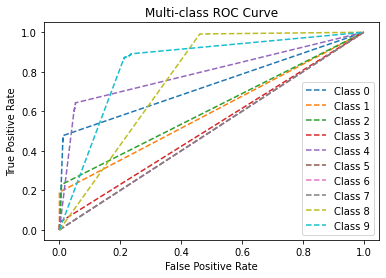

auc_score 0.6354735555555557


In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

false_positive_rate = {}
true_positive_rate = {}
threshold = {}
n_class = 10

for i in range(n_class):
    false_positive_rate[i],true_positive_rate[i],threshold[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:,i],pos_label=i)
for i in range(n_class):
    plt.plot(false_positive_rate[i],true_positive_rate[i],linestyle='--',label=f"Class {i}")
    
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print("auc_score",roc_auc_score(test_labels_list,test_outputs_list,multi_class='ovo',average='macro'))

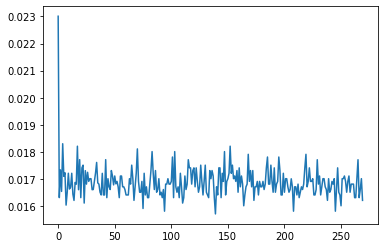

In [23]:
plt.plot(np.array(logs['tr_bce_loss']))

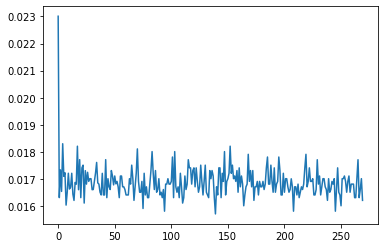

In [24]:
plt.plot(np.array(logs['tr_bce_loss']))